In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
#读取文件
data=pd.read_excel('data.xlsx')

任务1.1

In [3]:
data1_1 = data[['sARCH_ID','iFLOW_NODE_NO','dUPDATE_TIME','dNODE_TIME','iNODE_STATUS']]
#从data表中提取需要的列，发现缺失值（工序未完成）使用删除行处理
data1_1 = data1_1.dropna()
#提取各个工序数据并且剔除‘iFLOW_NODE_NO’
data1_1_sm = data1_1[data1_1['iFLOW_NODE_NO'] == 1][['sARCH_ID','dUPDATE_TIME','dNODE_TIME']]
data1_1_cl = data1_1[data1_1['iFLOW_NODE_NO'] == 2][['sARCH_ID','dUPDATE_TIME','dNODE_TIME']]
data1_1_jc = data1_1[data1_1['iFLOW_NODE_NO'] == 3][['sARCH_ID','dUPDATE_TIME','dNODE_TIME']]
data1_1_pdf = data1_1[data1_1['iFLOW_NODE_NO'] == 4][['sARCH_ID','dUPDATE_TIME','dNODE_TIME']]
#修改列名便于识别
data1_1_sm = data1_1_sm.rename(columns={'sARCH_ID':'案卷号','dUPDATE_TIME':'扫描开始时间','dNODE_TIME':'扫描结束时间'})
data1_1_cl = data1_1_cl.rename(columns={'sARCH_ID':'案卷号','dUPDATE_TIME':'图像处理开始时间','dNODE_TIME':'图像处理结束时间'})
data1_1_jc = data1_1_jc.rename(columns={'sARCH_ID':'案卷号','dUPDATE_TIME':'自检全检开始时间','dNODE_TIME':'自检全检结束时间'})
data1_1_pdf = data1_1_pdf.rename(columns={'sARCH_ID':'案卷号','dUPDATE_TIME':'PDF处理开始时间','dNODE_TIME':'PDF处理结束时间'})
#合并数据
data1_1_result = pd.merge(data1_1_sm, data1_1_cl, on = '案卷号')
data1_1_result = pd.merge(data1_1_result, data1_1_jc, on = '案卷号')
data1_1_result = pd.merge(data1_1_result, data1_1_pdf, on = '案卷号')


In [4]:
#统计完成四道工序的案卷号
data1_1_result.count()

案卷号          33980
扫描开始时间       33980
扫描结束时间       33980
图像处理开始时间     33980
图像处理结束时间     33980
自检全检开始时间     33980
自检全检结束时间     33980
PDF处理开始时间    33980
PDF处理结束时间    33980
dtype: int64

In [5]:
import datetime
def calculate_working_hours(start_time, end_time):
    # 定义工作时间段
    working_days = [0,1,2,3,4,5]
    working_hours = {
        'start_morning': (8, 30, 0),
        'end_morning': (12, 0, 0),
        'start_afternoon': (13, 0, 0),
        'end_afternoon': (18, 0, 0)
    }

    # 将时间字符串转换为 datetime 对象
    start_datetime = start_time
    end_datetime = end_time

    # 初始化工作时长为0
    working_duration = datetime.timedelta()

    # 遍历两个时间之间的每一天
    current_datetime = start_datetime
    while current_datetime.date() <= end_datetime.date():
        # 检查是否为工作日
        if current_datetime.weekday() in working_days:
            rest_time = datetime.timedelta()
            # 设置当日上午工作时间段
            morning_start = datetime.datetime(
                current_datetime.year, current_datetime.month, current_datetime.day,
                working_hours['start_morning'][0], working_hours['start_morning'][1],
                working_hours['start_morning'][2]
            )
            morning_end = datetime.datetime(
                current_datetime.year, current_datetime.month, current_datetime.day,
                working_hours['end_morning'][0], working_hours['end_morning'][1],
                working_hours['end_morning'][2]
            )

            # 设置当日下午工作时间段
            afternoon_start = datetime.datetime(
                current_datetime.year, current_datetime.month, current_datetime.day,
                working_hours['start_afternoon'][0], working_hours['start_afternoon'][1],
                working_hours['start_afternoon'][2]
            )
            afternoon_end = datetime.datetime(
                current_datetime.year, current_datetime.month, current_datetime.day,
                working_hours['end_afternoon'][0], working_hours['end_afternoon'][1],
                working_hours['end_afternoon'][2]
            )
            #不跨天
            if start_datetime.date() == end_datetime.date():
                if start_datetime <= morning_end and end_datetime >= afternoon_start:
                    rest_time = afternoon_start - morning_end
                overlap_start = current_datetime
                overlap_end = end_datetime
            #跨天
            else:
                #跨天第一天
                if current_datetime.date() == start_datetime.date():
                    overlap_start = start_datetime
                    overlap_end = afternoon_end
                    
                    if start_datetime <= morning_end:
                        rest_time = afternoon_start - morning_end
                #第N天
                elif current_datetime.date() != start_datetime.date() and current_datetime.date() != end_datetime.date():
                    overlap_end = morning_start
                    overlap_start = afternoon_end
                    rest_time = afternoon_start - morning_end
                #最后一天
                elif current_datetime.date() == end_datetime.date():
                    overlap_start = morning_start
                    overlap_end = end_datetime
                    
                    if end_datetime >= morning_end:
                        rest_time = afternoon_start - morning_end
            # 累加工作时长
            if overlap_start < overlap_end:
                working_duration += overlap_end - overlap_start - rest_time

        # 增加一天
        current_datetime += datetime.timedelta(days = 1)

    # 返回工作时长
    return working_duration
list_sm = []
list_tx = []
list_jc = []


for index, row in data1_1_result[['扫描结束时间','扫描开始时间']].iterrows():
    time2, time1 = row['扫描结束时间'], row['扫描开始时间']
    duration = calculate_working_hours(time1, time2)
    working_hours = duration.total_seconds() / 3600
    list_sm.append(working_hours)

#图像处理时间
for index, row in data1_1_result[['图像处理结束时间','图像处理开始时间']].iterrows():
    time2, time1 = row['图像处理结束时间'], row['图像处理开始时间']
    duration = calculate_working_hours(time1, time2)
    working_hours = duration.total_seconds() / 3600
    list_tx.append(working_hours)

#自检全检时间
for index, row in data1_1_result[['自检全检结束时间','自检全检开始时间']].iterrows():
    time2, time1 = row['自检全检结束时间'], row['自检全检开始时间']
    duration = calculate_working_hours(time1, time2)
    working_hours = duration.total_seconds() / 3600
    list_jc.append(working_hours)

#三个工序时间相加
result = []
for i in range(len(list_sm)):
    sum_value = list_sm[i] + list_tx[i] + list_jc[i]
    sum_value = round(sum_value, 3)
    result.append(sum_value)
    
#传入data1_1_result

data1_1_result['完成时长'] = result

In [6]:
df=data1_1_result.sort_values(by='完成时长', ascending=False)

# 选择前三个案卷
top_3_cases = df.head(3)

print(top_3_cases)

             案卷号                  扫描开始时间              扫描结束时间  \
4426  托942288-册一 2020-07-02 08:49:45.273 2020-07-07 11:22:09   
4405  托942290-册一 2020-07-02 08:49:45.297 2020-07-07 11:18:03   
4808  托942294-册一 2020-07-02 08:49:45.367 2020-07-07 12:07:02   

                图像处理开始时间            图像处理结束时间            自检全检开始时间  \
4426 2020-07-07 13:17:49 2020-07-08 11:14:10 2020-07-17 10:41:53   
4405 2020-07-07 13:17:49 2020-07-08 11:16:46 2020-07-17 10:41:53   
4808 2020-07-07 13:17:50 2020-07-08 11:21:51 2020-07-17 10:41:53   

                自检全检结束时间           PDF处理开始时间           PDF处理结束时间    完成时长  
4426 2020-07-18 09:15:50 2020-07-18 09:32:52 2020-07-18 09:48:12  25.545  
4405 2020-07-18 09:15:54 2020-07-18 09:32:52 2020-07-18 09:48:12  25.521  
4808 2020-07-18 09:16:10 2020-07-18 09:32:53 2020-07-18 09:48:13  25.426  


In [7]:
data1_1_result1=data1_1_result.set_index('案卷号')
data1_1_result1.to_excel('result1_1.xlsx')

任务1.2

In [8]:
#找出需要返回工序的index
null_idx=data.loc[data['dPROC_TIME'].isnull(),:].index
#将不需要返回工序的剔除
data1_2=data.drop(null_idx)
data1_2 = data1_2[['sARCH_ID','iFLOW_NODE_NO','dUPDATE_TIME','dNODE_TIME','dPROC_TIME','iNODE_STATUS']]
# 筛选出iNODE_STATUS为5的数据，并选择需要的列
data1_2 = data1_2[data1_2['iNODE_STATUS'] == 5][['sARCH_ID','dUPDATE_TIME','dNODE_TIME','dPROC_TIME','iFLOW_NODE_NO']]
# 统计
review=data1_2['sARCH_ID'].count()
#计算百分比
percent_1=review/data1_1_result['案卷号'].count()
print('返工的案卷数量：{}'.format(review))
print('百分比{}'.format(percent_1))

返工的案卷数量：797
百分比0.023454973513831665


In [9]:
# 根据iFLOW_NODE_NO值筛选不同流程节点的数据，并选择需要的列
data1_2_sm = data1_2[data1_2['iFLOW_NODE_NO'] == 1][['sARCH_ID','dUPDATE_TIME','dNODE_TIME','dPROC_TIME']]
data1_2_cl = data1_2[data1_2['iFLOW_NODE_NO'] == 2][['sARCH_ID','dUPDATE_TIME','dNODE_TIME','dPROC_TIME']]
data1_2_jc = data1_2[data1_2['iFLOW_NODE_NO'] == 3][['sARCH_ID','dUPDATE_TIME','dNODE_TIME','dPROC_TIME']]
data1_2_pdf = data1_2[data1_2['iFLOW_NODE_NO'] == 4][['sARCH_ID','dUPDATE_TIME','dNODE_TIME','dPROC_TIME']]
# 重命名列名
data1_2_sm = data1_2_sm.rename(columns={'sARCH_ID':'案卷号','dUPDATE_TIME':'扫描开始时间','dNODE_TIME':'扫描结束时间','dPROC_TIME':'返工'})
data1_2_cl = data1_2_cl.rename(columns={'sARCH_ID':'案卷号','dUPDATE_TIME':'图像处理开始时间','dNODE_TIME':'图像处理结束时间','dPROC_TIME':'返工'})
data1_2_jc = data1_2_jc.rename(columns={'sARCH_ID':'案卷号','dUPDATE_TIME':'自检全检开始时间','dNODE_TIME':'自检全检结束时间','dPROC_TIME':'返工时间'})
data1_2_pdf = data1_2_pdf.rename(columns={'sARCH_ID':'案卷号','dUPDATE_TIME':'PDF处理开始时间','dNODE_TIME':'PDF处理结束时间','dPROC_TIME':'返工时间'})
# 合并结果
data1_2_result = pd.merge(data1_2_sm, data1_2_cl, on = '案卷号',how='outer')
data1_2_result = pd.merge(data1_2_result, data1_2_jc, on = '案卷号',how='outer')
data1_2_result = pd.merge(data1_2_result, data1_2_pdf, on = '案卷号',how='outer')
# 删除不需要的列
data1_2_result=data1_2_result.drop(['扫描开始时间','扫描结束时间','图像处理开始时间','图像处理结束时间','自检全检开始时间','自检全检结束时间','PDF处理开始时间','PDF处理结束时间'],axis=1)
# 重命名列名
data1_2_result = data1_2_result.rename(columns={'返工_x':'扫描时间','返工_y':'图像处理','返工时间_x':'自检全检','返工时间_y':'PDF处理'})
# 将案卷号设置为索引
data1_2_result=data1_2_result.set_index('案卷号')
# 导出结果到Excel文件
data1_2_result.to_excel('result1_2.xlsx')

任务1.3

In [10]:
data1_3 = data[data['sNODE_NAME'] == '自检全检']
data1_3_count = data1_3.groupby(by = 'iUSER_ID')['iID'].count()
data1_3_count_df = data1_3_count.to_frame(name = 'Count')
data1_3_result = data1_3_count_df['Count'].apply(lambda x: round(x / len(data1_3)*100, 3))
data1_3_result_df = data1_3_result.to_frame(name = '返工案卷占比（%）')
data1_3_result_df.index.name = '操作人员ID'
data1_3_result_df.to_excel('result1_3.xlsx')
data1_3_result_df

返工案卷占比（%）
操作人员ID           
8           0.038
10         34.071
12         24.537
13         21.256
17          0.068
24          0.009
42         18.502
87          1.518

任务1.4

In [11]:
data1_4_dropna = data[['iID','iFLOW_NODE_NO','dNODE_TIME']].dropna()
data1_4 = data1_4_dropna.groupby(by = 'iFLOW_NODE_NO').count()
data1_4.index = ['扫描','图像处理','自检全检','PDF处理']
data1_4.index.name = '工序'

In [12]:
min_sm = data1_1_result['扫描开始时间'].min()
max_sm = data1_1_result['扫描结束时间'].max()
min_tx = data1_1_result['图像处理开始时间'].min()
max_tx = data1_1_result['图像处理结束时间'].max()
min_jc = data1_1_result['自检全检开始时间'].min()
max_jc = data1_1_result['自检全检结束时间'].max()
min_pdf = data1_1_result['PDF处理开始时间'].min()
max_pdf = data1_1_result['PDF处理结束时间'].max()
min_list = [min_sm, min_tx, min_jc, min_pdf]
min_list
max_list = [max_sm, max_tx, max_jc, max_pdf]
max_list
sum_time_list = []
for i in range(4):
    duration = max_list[i] - min_list[i]
    working_hours = round(duration.total_seconds() / 3600,3)
    sum_time_list.append(working_hours)
#计算PDF处理的均值
list_pdf = []
for index, row in data1_1_result[['PDF处理结束时间','PDF处理开始时间']].iterrows():
    time2, time1 = row['PDF处理结束时间'], row['PDF处理开始时间']
    duration = calculate_working_hours(time1, time2)
    working_hours = duration.total_seconds() / 3600
    list_pdf.append(working_hours)
mean_sm = sum(list_sm) / len(list_sm)
mean_tx = sum(list_tx) / len(list_tx)
mean_jc = sum(list_jc) / len(list_jc)
mean_pdf = sum(list_pdf) / len(list_pdf)
mean_list = [mean_sm, mean_tx, mean_jc, mean_pdf]
mean_time_list = []
for i in range(4):
    mean_time_list.append(round(mean_list[i],3))
data1_4 = data1_4.drop('dNODE_TIME',axis = 1)
data1_4 = data1_4.rename(columns={'iID': '完成案卷的数量'})
data1_4['总耗时（h）'] = sum_time_list
data1_4['平均耗时 （h/卷）'] = mean_time_list
data1_4.to_excel('result1_4.xlsx')

In [13]:
data1_4

完成案卷的数量   总耗时（h）  平均耗时 （h/卷）
工序                                 
扫描       33985  704.077       3.072
图像处理     33985  721.543       1.907
自检全检     33985  718.981       1.452
PDF处理    33980  698.116       0.727

任务1.5

In [40]:
data1_5 = data[['sARCH_ID','dUPDATE_TIME','dNODE_TIME','sNODE_NAME','iUSER_ID']]
data1_5 = data1_5.dropna()

In [41]:
data1_5_sm = data1_1_result[['案卷号','扫描开始时间','扫描结束时间']]
data1_5_tx = data1_1_result[['案卷号','图像处理开始时间','图像处理结束时间']]
data1_5_jc = data1_1_result[['案卷号','自检全检开始时间','自检全检结束时间']]
data1_5_pdf = data1_1_result[['案卷号','PDF处理开始时间','PDF处理结束时间']]
data1_5_sm['扫描完成时间'] = list_sm
data1_5_tx['图像处理完成时间'] = list_tx
data1_5_jc['自检全检完成时间'] = list_jc
data1_5_pdf['PDF处理完成时间'] = list_pdf

C:\Users\93594\AppData\Local\Temp\ipykernel_6604\2712798065.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_5_sm['扫描完成时间'] = list_sm
C:\Users\93594\AppData\Local\Temp\ipykernel_6604\2712798065.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_5_tx['图像处理完成时间'] = list_tx
C:\Users\93594\AppData\Local\Temp\ipykernel_6604\2712798065.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [42]:
data1_5_sm_main = data1_5[data1_5['sNODE_NAME'] == '扫描']
data1_5_tx_main = data1_5[data1_5['sNODE_NAME'] == '图像处理']
data1_5_jc_main = data1_5[data1_5['sNODE_NAME'] == '自检全检']
data1_5_pdf_main = data1_5[data1_5['sNODE_NAME'] == 'PDF处理']

data1_5_sm_main = data1_5_sm_main.rename(columns={'sARCH_ID':'案卷号','dUPDATE_TIME':'扫描开始时间','dNODE_TIME':'扫描结束时间','sNODE_NAME':'工序','iUSER_ID':'操作人员ID'})
data1_5_tx_main = data1_5_tx_main.rename(columns={'sARCH_ID':'案卷号','dUPDATE_TIME':'图像处理开始时间','dNODE_TIME':'图像处理结束时间','sNODE_NAME':'工序','iUSER_ID':'操作人员ID'})
data1_5_jc_main = data1_5_jc_main.rename(columns={'sARCH_ID':'案卷号','dUPDATE_TIME':'自检全检开始时间','dNODE_TIME':'自检全检结束时间','sNODE_NAME':'工序','iUSER_ID':'操作人员ID'})
data1_5_pdf_main = data1_5_pdf_main.rename(columns={'sARCH_ID':'案卷号','dUPDATE_TIME':'PDF处理开始时间','dNODE_TIME':'PDF处理结束时间','sNODE_NAME':'工序','iUSER_ID':'操作人员ID'})

In [43]:
data1_5_sm_main = pd.merge(data1_5_sm_main, data1_5_sm, on=['案卷号','扫描开始时间','扫描结束时间'])
data1_5_tx_main = pd.merge(data1_5_tx_main, data1_5_tx, on=['案卷号','图像处理开始时间','图像处理结束时间'])
data1_5_jc_main = pd.merge(data1_5_jc_main, data1_5_jc, on=['案卷号','自检全检开始时间','自检全检结束时间'])
data1_5_pdf_main = pd.merge(data1_5_pdf_main, data1_5_pdf, on=['案卷号','PDF处理开始时间','PDF处理结束时间'])

In [44]:
data1_5_sm_result = pd.concat([data1_5_sm_main.groupby('操作人员ID')['案卷号'].count(),data1_5_sm_main.groupby('操作人员ID')['扫描完成时间'].sum()], axis=1)
data1_5_tx_result = pd.concat([data1_5_tx_main.groupby('操作人员ID')['案卷号'].count(),data1_5_tx_main.groupby('操作人员ID')['图像处理完成时间'].sum()], axis=1)
data1_5_jc_result = pd.concat([data1_5_jc_main.groupby('操作人员ID')['案卷号'].count(),data1_5_jc_main.groupby('操作人员ID')['自检全检完成时间'].sum()], axis=1)
data1_5_pdf_result = pd.concat([data1_5_pdf_main.groupby('操作人员ID')['案卷号'].count(),data1_5_pdf_main.groupby('操作人员ID')['PDF处理完成时间'].sum()], axis=1)

In [45]:
data1_5_sm_result['工序'] = '扫描'
data1_5_tx_result['工序'] = '图像处理'
data1_5_jc_result['工序'] = '自检全查'
data1_5_pdf_result['工序'] = 'PDF处理'
data1_5_sm_result = data1_5_sm_result.rename(columns={'案卷号':'完成案卷的数量','扫描完成时间':'工作时长'})
data1_5_tx_result = data1_5_tx_result.rename(columns={'案卷号':'完成案卷的数量','图像处理完成时间':'工作时长'})
data1_5_jc_result = data1_5_jc_result.rename(columns={'案卷号':'完成案卷的数量','自检全检完成时间':'工作时长'})
data1_5_pdf_result = data1_5_pdf_result.rename(columns={'案卷号':'完成案卷的数量','PDF处理完成时间':'工作时长'})
data1_5_result = pd.concat([data1_5_sm_result,data1_5_tx_result,data1_5_jc_result,data1_5_pdf_result],axis = 0,join = 'outer')

In [52]:
data1_5_result['每个案卷的平均耗时 （h/卷）'] = data1_5_result[['工作时长','完成案卷的数量']].apply(lambda x:(x[0] / x[1]),axis = 1)
data1_5_result = data1_5_result.sort_index()
data1_5_result = data1_5_result[['工序','工作时长','完成案卷的数量','每个案卷的平均耗时 （h/卷）']]
data1_5_result['每个案卷的平均耗时 （h/卷）'] = data1_5_result['每个案卷的平均耗时 （h/卷）'].round(3)
data1_5_result['工作时长'] = data1_5_result['工作时长'].round(3)

In [53]:
data1_5_result.to_excel('result1_5.xlsx')

任务二

任务2.1

In [14]:
#提取扫描工序的数据
saomiao = data.loc[data['sNODE_NAME']=='扫描']

#提取图像处理工序的数据  
pict = data.loc[data['sNODE_NAME']=='图像处理']

#提取PDF处理工序的数据
pdf = data.loc[data['sNODE_NAME']=='PDF处理'] 

#提取自检全检工序的数据  
zijian = data.loc[data['sNODE_NAME']=='自检全检']

#为各工序的数据取出日期部分,只保留日期
saomiao['day'] = saomiao['dUPDATE_TIME'].dt.date  
pict['day'] = pict['dUPDATE_TIME'].dt.date
pdf['day'] = pdf['dUPDATE_TIME'].dt.date
zijian['day'] = zijian['dUPDATE_TIME'].dt.date

C:\Users\93594\AppData\Local\Temp\ipykernel_6604\2724105641.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  saomiao['day'] = saomiao['dUPDATE_TIME'].dt.date
C:\Users\93594\AppData\Local\Temp\ipykernel_6604\2724105641.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pict['day'] = pict['dUPDATE_TIME'].dt.date
C:\Users\93594\AppData\Local\Temp\ipykernel_6604\2724105641.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [15]:
# 提取扫描工序中'day'列(日期)的值计数,作为一个Series返回
df2 = saomiao.day.value_counts() 

#提取图像处理工序中'day'列(日期)的值计数,作为一个Series返回
df3 = pict.day.value_counts()

#提取PDF处理工序中'day'列(日期)的值计数,作为一个Series返回  
df4 = pdf.day.value_counts()

#提取自检全检工序中'day'列(日期)的值计数,作为一个Series返回
df5 = zijian.day.value_counts()

In [16]:
# 将扫描工序值计数系列按索引(日期)进行升序排序,转换为数据框 
saodata = pd.DataFrame(df2.sort_index())

# 将图像处理工序值计数系列按索引(日期)进行升序排序,转换为数据框
pictdata = pd.DataFrame(df3.sort_index()) 

# 将PDF处理工序值计数系列按索引(日期)进行升序排序,转换为数据框
pdfdata = pd.DataFrame(df4.sort_index())

# 将自检全检工序值计数系列按索引(日期)进行升序排序,转换为数据框  
jiandata = pd.DataFrame(df5.sort_index())

# 将上述4个数据框在列上进行外连接合并
data1 = pd.concat([saodata,pdfdata,pictdata,jiandata],axis=1,join='outer') 

# 重置数据框列名
data1.columns =['saodata','pdfdata','pictdata','jiandata']


In [17]:
# 设置matplotlib支持中文显示
plt.rcParams['font.sans-serif']=['SimHei']

# 定义x轴日期标签  


labels=['2020-07-01', '2020-07-02', '2020-07-03', '2020-07-06', '2020-07-07', '2020-07-08',
       '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-13', '2020-07-14', '2020-07-15',
       '2020-07-16', '2020-07-17', '2020-07-18', '2020-07-20', '2020-07-21', '2020-07-22',
       '2020-07-23', '2020-07-24', '2020-07-25', '2020-07-27', '2020-07-28', '2020-07-29',
       '2020-07-30', '2020-07-31']
# 生成x轴位置数组
x = np.arange(len(labels))  

# 设置bar图宽度
width = 0.25

# 绘制图形  
fig, ax = plt.subplots(figsize=(16,9))

# 绘制扫描部分条形图
rects1 = ax.bar(x - width/2, data1['saodata'], width, label='扫描')

# 绘制PDF处理部分条形图  
rects2 = ax.bar(x + width/2, data1['pdfdata'], width, label='pdf处理') 

# 绘制图像处理部分条形图
rects3 = ax.bar(x - width/4, data1['pictdata'], width, label='图像处理')

# 绘制自检全检部分条形图
rects4 = ax.bar(x + width/4, data1['jiandata'], width, label='自检全检')

# 添加标签、标题等
ax.set_ylabel('完成量')
ax.set_title('每日完成量')

# 设置x坐标刻度点与标签
ax.set_xticks(x)
ax.set_xticklabels(labels)

# 添加图例
ax.legend()

任务2.2

In [18]:
import datetime
saomiao['work'] =saomiao['dNODE_TIME'] - saomiao['dUPDATE_TIME']
pict['work'] = pict['dNODE_TIME'] - pict['dUPDATE_TIME']
pdf['work'] = pdf['dNODE_TIME'] - pdf['dUPDATE_TIME']
zijian['work'] = zijian['dNODE_TIME'] - zijian['dUPDATE_TIME']

C:\Users\93594\AppData\Local\Temp\ipykernel_6604\84339136.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  saomiao['work'] =saomiao['dNODE_TIME'] - saomiao['dUPDATE_TIME']
C:\Users\93594\AppData\Local\Temp\ipykernel_6604\84339136.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pict['work'] = pict['dNODE_TIME'] - pict['dUPDATE_TIME']
C:\Users\93594\AppData\Local\Temp\ipykernel_6604\84339136.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [19]:
import datetime

saowork = saomiao[['day','work']].groupby(by = 'day').sum()
saowork['work']=saowork['work'] /np.timedelta64(1, 'h')
pictwork = pict[['day','work']].groupby(by = 'day').sum()
pictwork['work']=pictwork['work'] /np.timedelta64(1, 'h')
pdfwork = pdf[['day','work']].groupby(by = 'day').sum()
pdfwork['work'] =pdfwork['work'] /np.timedelta64(1, 'h')
zijianwork = zijian[['day','work']].groupby(by = 'day').sum()
zijianwork['work']=zijianwork['work'] /np.timedelta64(1, 'h')



In [20]:
data2 = pd.concat([saowork,pdfwork,pictwork,zijianwork],axis=1,join='outer')
data2.columns =['saowork','pdfwork','pictwork','zijianwork']
data2

saowork      pdfwork      pictwork    zijianwork
day                                                              
2020-07-01  30182.568088          NaN    939.491111      0.015278
2020-07-02  65797.663424     0.012778   3832.096944   1719.422778
2020-07-03  60989.064802   365.767222  18326.015556   4783.500556
2020-07-06  32580.710339   594.254444   6695.457222   4310.220278
2020-07-07  18462.838490   166.577222  10309.217778   1533.139167
2020-07-08  10489.527743  6576.633889   9483.445278   4780.485278
2020-07-09   4696.821813   286.772222   9556.305000   5688.962500
2020-07-10   5020.958805  4197.515556   6050.675556   3510.403056
2020-07-11  10955.352863  2488.045278   4448.678611   9583.616111
2020-07-13  47654.555112   662.507500  10137.075000   3333.965833
2020-07-14   9089.653254  6169.363611  10016.003056   3085.871111
2020-07-15  19391.761536  6586.415556  11347.749722   3355.102778
2020-07-16  14360.692438  2784.091667   3986.227778   4006.263333
2020-07-17  16541.305689   670.422500   4680.325556   5278.131111
2020-07-18  16573.302440  1456.708333  15174.443333  12388.255833
2020-07-20   9509.757156   816.451111   7597.849444  10485.118889
2020-07-21  11131.554267   545.211389   4278.917222   8187.392222
2020-07-22   9566.244048   352.813889   8642.671389   5486.147500
2020-07-23   2521.746753  3261.206111   8805.151111   8253.005000
2020-07-24   3908.566748    21.907222   9148.687778   6338.392778
2020-07-25  18653.499835  4926.815278   6377.018889  17833.873611
2020-07-27   6979.778574   658.538611   7190.843889   7302.805000
2020-07-28   3444.643357  1360.756667   4822.205000   6481.435278
2020-07-29   4160.918220  3435.586389   6385.757778   8956.538889
2020-07-30    627.678463  1427.850000   4897.573889   6398.434444
2020-07-31           NaN  1247.413056    711.266389   1719.240833

Text(0, 0.5, '工作量')

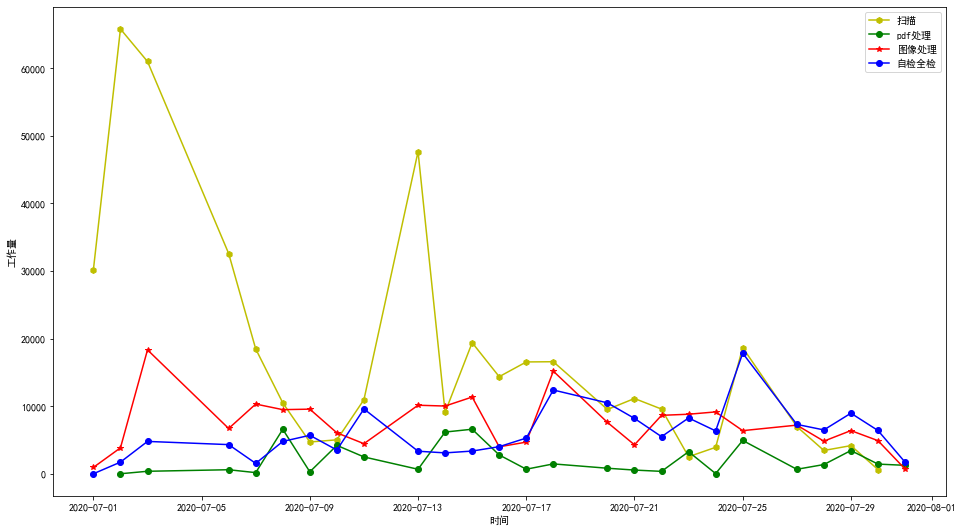

In [21]:
import matplotlib.pyplot as plt

x = data2.index
plt.figure(figsize=(16,9))
plt.plot(x, data2['saowork'],'yh-',label='扫描')
plt.plot(x, data2['pdfwork'],'go-', label='pdf处理')
plt.plot(x, data2['pictwork'],'r*-',label='图像处理')
plt.plot(x, data2['zijianwork'],'bo-', label='自检全检')
plt.legend()
plt.xlabel('时间')
plt.ylabel('工作量')

任务2.3

In [22]:
saoback = saomiao.loc[saomiao['iNODE_STATUS']==5].day.value_counts()
pictback = pict.loc[pict['iNODE_STATUS']==5].day.value_counts()
pdfback = pdf.loc[pdf['iNODE_STATUS']==5].day.value_counts()
zijianback =zijian.loc[zijian['iNODE_STATUS']==5].day.value_counts()


In [23]:
data3 = pd.concat([saoback,pdfback,pictback,zijianback],axis=1,join='outer')
data3.columns =['saoback','pdfback','pictback','zijianback']

data3['sum'] =data3['saoback']+data3['pdfback']+data3['pictback']+data3['zijianback']

dcd = data1[['saodata']]
data3 = pd.concat([data3,dcd],axis=1,join='outer')[['saoback','pdfback','pictback','zijianback']]
data3 = data3.fillna(0)
data3['sum'] =data3['saoback']+data3['pdfback']+data3['pictback']+data3['zijianback']

In [24]:
data3['saoback'] = data3['saoback']/data3['sum']
data3['pdfback'] = data3['pdfback']/data3['sum']
data3['pictback'] = data3['pictback']/data3['sum']
data3['zijianback'] = data3['zijianback']/data3['sum']
data3 = data3.fillna(0)
data3 =data3.sort_index()

In [25]:
p = plt.figure(figsize=(16,9),dpi=1080)
x = data3.index


# 绘制堆积面积图
plt.stackplot(x,data3['saoback'],data3['pdfback'],data3['pictback'],data3['zijianback'],colors= ['r','g','y','b'],labels=['扫描', 'PDF处理', '图像处理', '自检全检'])
plt.xlabel('日期')
plt.ylabel('百分比')
plt.legend()
plt.title('返工案卷百分比')
plt.show()

任务2.4

In [26]:
pictcheck0 = pict.loc[pict['iNODE_STATUS']==5].iUSER_ID.value_counts()
pictcheck = np.array(pictcheck0)
pictcheck[9] =pictcheck[10]+pictcheck[11]+pictcheck[12]+pictcheck[9]
pictcheck =pictcheck[:10]

In [27]:
import matplotlib.pyplot as plt
explode = [0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]
label = ['48', '73', '19', '76', '95', '91', '94', '71', '98', 'other']
p = plt.figure(figsize=(16,9),dpi=1080)
plt.pie(pictcheck,explode=explode,labels =label,autopct='%1.1f%%' )
plt.title('图像员工返工案数比例图')
plt.show()

任务三

任务3.1

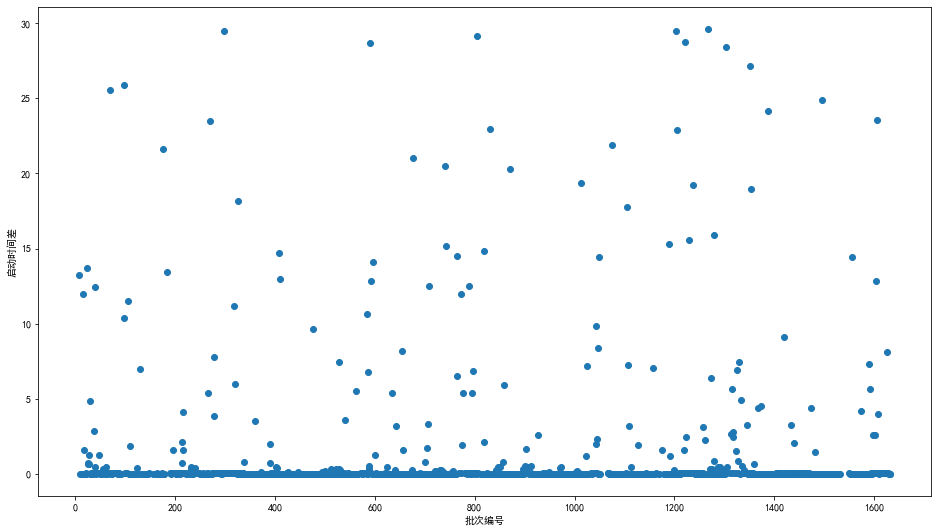

In [29]:
start_time =data[data[['dPROC_TIME']].isnull().T.any()][['dUPDATE_TIME','dPROC_TIME','sBatch_number']]

cmit = start_time[['dUPDATE_TIME','sBatch_number']].groupby(by = 'sBatch_number').max()-start_time[['dUPDATE_TIME','sBatch_number']].groupby(by = 'sBatch_number').min()
cmit['dUPDATE_TIME']=cmit['dUPDATE_TIME'] /np.timedelta64(1, 'm')
cmit = cmit[cmit['dUPDATE_TIME'] < 30.0]
plt.figure(figsize=(16,9))
plt.scatter(cmit.index,cmit['dUPDATE_TIME'])
plt.xlabel('批次编号')
plt.ylabel('启动时间差')
plt.show()